# 🤗 Diffusers Walk-through

In recent months, it has become clear that diffusion models have taken the throne as the state-of-the-art generative models. Here, we will use HuggingFace's brand new [Diffusers](https://github.com/huggingface/diffusers) library to train a simple diffusion model. Hopefully it is flexible enough to allow you to also try training on your own datasets with different models.

## Installs and Imports

First you must install the Hugging Face Diffusers library. Since it is brand new, with many changes still being made daily, it is probably best to install directly from the GitHub repository.

Tools like [Accelerate](https://github.com/huggingface/accelerate), [Datasets](https://github.com/huggingface/datasets), and [Weights and Biases](https://wandb.ai) are also installed and used in this tutorial.

Let's install and import all these packages:

In [1]:
!pip install git+https://github.com/huggingface/diffusers.git
!pip install wandb
!pip install accelerate
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-38ocaryd
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-38ocaryd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 101 kB 11.9 MB/s 
     |████████████████████████████████| 596 kB 62.0 MB/s 
  Created wheel for diffusers: filename=diffusers-0.0.4-py3-none-any.whl size=127788 sha256=6031e6b2a59685ac51f765bcc40a2e78506badf2673152fcc444b684ac1c0dac
  Stored in directory: /tmp/pip-ephem-wheel-cache-ham3xo34/wheels/02/d2/24/9d4a75289c359ffceca56b42aecb8e8fbf659c455bcd4d2eca
Successfully built diffusers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking 

In [2]:
import torch
import torch.nn.functional as F
import os
import math
import wandb
from accelerate import Accelerator, notebook_launcher
from diffusers import DDPMPipeline, DDPMScheduler, UNetModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from tqdm.auto import tqdm
from datasets import load_dataset
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

## Config

Here we define our configuration. This would be similar to the arguments used for a training script.

In [3]:
class Config:
    size=128
    batch_size = 16
    num_to_sample = 16
    epochs = 100
    grad_accum_steps = 1
    lr=1e-4
    warmup_steps = 500
    ema_inv_gamma = 1.0
    ema_power = 0.75
    ema_max_decay = 0.9999
    save_model_freq = 10
    mixed_precision = 'fp16'
    output_dir = 'diffusers_butterflies_128_ema'
    wandb = {'entity': 'tmabraham', 'project': 'diffusers_notebook', 'group': 'butterflies_128', 'save_model': True}
    
Config.tfms = transforms.Compose([
        transforms.Resize(Config.size, interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.CenterCrop(Config.size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

## Dataset loading

Here we will load our dataset using the HuggingFace Datasets library. We will use [this butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) dataset. You can replace this code section with your own dataset loading code.

In [4]:
def augs(examples):
    images = [Config.tfms(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

In [5]:
def load_your_dataset():
    dataset = load_dataset('huggan/smithsonian_butterflies_subset')
    dataset.set_transform(augs)
    return dataset['train']

In [6]:
dataset = load_your_dataset()

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Using custom data configuration huggan--smithsonian_butterflies_subset-dca27cc6049931aa


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-dca27cc6049931aa/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Parameter 'transform'=<function augs at 0x7f1599a4e050> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.batch_size, shuffle=True)

## Diffusion model setup:

Here we set up our diffusion model. Remember that for diffusion models, we give our model a noisy image at the current time-step, and our model predicts the noise residual that would give us a less noisy image.

Most diffusion models use architectures that are some variant of a U-net and that's what we'll use here. Diffusers provides us a handy `UnetModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size:

In [8]:
model = UNetModel(resolution=Config.size)

In [9]:
sample_image = dataset[0]['images'].unsqueeze(0)

In [10]:
print('Output shape:', model(sample_image,timesteps=0).shape)

Output shape: torch.Size([1, 3, 128, 128])


We confirm that passing in our 128x128 image results in an output of the same size.

Note that our model takes in the (noisy) image and also the current time-step. How is that time-step information incorporated in the U-net model? The most common approach is to treat the timesteps as another embedding that can be added, just like a positional embedding for Transformers. You can see that in the code over [here](https://github.com/huggingface/diffusers/blob/abedfb08f18c37d620ebd64f77db7ce89a7454b4/src/diffusers/models/resnet.py#L352). 

One of the key aspects of diffusion models is the noise scheduling, where we iteratively add noise to the original image in accordance to a predefined noise schedule. Different models may have different noise schedules, and here we are going to use schedule for [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

In [11]:
noise_scheduler = DDPMScheduler(timesteps=1000, tensor_format="pt")

Let's show how this noise schedule works:

In [12]:
print(noise_scheduler.timesteps)

1000


You can see the variance of the noise keeps growing as the timestep increases:

In [13]:
[noise_scheduler.get_variance(t) for t in range(noise_scheduler.timesteps)][::100]

[tensor(1.0000e-20, dtype=torch.float64),
 tensor(0.0021),
 tensor(0.0041),
 tensor(0.0061),
 tensor(0.0081),
 tensor(0.0101),
 tensor(0.0120),
 tensor(0.0140),
 tensor(0.0160),
 tensor(0.0180)]

The noise scheduler can handle the final calculation of the noisy image given a specific timestep as we see here. This is basically conducting the "forward diffusion process" for the model:

In [14]:
noisy_image = noise_scheduler.add_noise(sample_image, torch.randn(sample_image.shape), torch.LongTensor([50])) # forward diffusion process

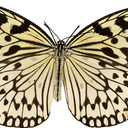

In [15]:
Image.fromarray(((sample_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

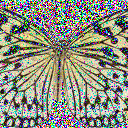

In [16]:
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

## Training functions:

Let's use a standard AdamW optimizer and cosine LR schedule:

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr)

In [18]:
lr_scheduler = get_scheduler("cosine",
    optimizer=optimizer,
    num_warmup_steps=Config.warmup_steps,
    num_training_steps=(len(train_dataloader) * Config.epochs) // Config.grad_accum_steps,
)

Here is our training function. Here are some essential details:

* We use `Accelerator` from the HuggingFace Accelerate package to deal automatically with any advanced training tricks like multi-GPU training, gradient accumulation, mixed precision, etc.

* We use an exponentially-moving average (EMA) of the model since EMA model samples are much higher visual quality than base model samples.

* We use Weights and Biases to handle experiment tracking.


In [19]:
def train(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator()
    
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    ema_model = EMAModel(model, inv_gamma=Config.ema_inv_gamma, power=Config.ema_power, max_value=Config.ema_max_decay)
    
    use_wandb = accelerator.is_main_process and (Config.wandb is not None)
    if use_wandb:
        config = {k:v for k,v in vars(Config).items() if k[:2]!='__'}
        wandb.init(project=Config.wandb['project'], entity=Config.wandb['entity'], group=Config.wandb['group'], config=config, save_code=True)
        wandb.watch(model)
        
    for epoch in range(Config.epochs):
        train_loop(epoch, accelerator, model, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb)
        eval_loop(epoch, accelerator, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb)
        
    if use_wandb: wandb.finish()

Here is the actual training loop. 

The training is as simple as generating some random noise to add to the original image at some random time-step, predict that noise with our model, and then use the difference between the predicted noise and actual noise to update the model.

In [20]:
def train_loop(epoch, accelerator, model, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb):
    for i,batch in enumerate(tqdm(train_dataloader, disable=not accelerator.is_main_process)):
        x_0 = batch['images']
        eps = torch.randn(x_0.shape).to(x_0.device)
        bs = x_0.shape[0]
        t = torch.randint(0, noise_scheduler.timesteps, (bs,), device=x_0.device).long()
        x_t = noise_scheduler.add_noise(x_0, eps, t)
        
        if i % Config.grad_accum_steps != 0:
            with accelerator.no_sync(model):
                eps_pred = model(x_t, t)
                # predict the noise residual
                loss = F.mse_loss(eps_pred, eps)
                loss = loss / Config.grad_accum_steps
                accelerator.backward(loss)
        else:
            eps_pred = model(x_t, t)
            # predict the noise residual
            loss = F.mse_loss(eps_pred, eps)
            loss = loss / Config.grad_accum_steps
            accelerator.backward(loss)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            ema_model.step(model)
            optimizer.zero_grad()
        
        if use_wandb:
            num_steps = len(train_dataloader)*epoch + i
            wandb.log({'loss': loss.detach().item(), 'lr': optimizer.param_groups[0]["lr"]}, step=num_steps)

Here we have our evaluation loop. Diffusers has a "Pipeline" object which you can pass your model and noise schedule into and you can then generate from the model with the appropriate sampling procedure. That is being demonstrated here, where a batch of sample images are generated and saved as a grid to the disk and to Weights and Biases.

In [21]:
def eval_loop(epoch, accelerator, ema_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, use_wandb):
    if accelerator.is_main_process:
        with torch.no_grad():
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(ema_model.averaged_model), noise_scheduler=noise_scheduler)
            image_batch = pipeline(batch_size = Config.num_to_sample, generator=torch.manual_seed(999))
        image = make_grid(image_batch,nrow=math.ceil(Config.num_to_sample**0.5), padding=0)

        image_processed = image.cpu().permute(1,2,0)
        image_processed = (image_processed + 1.0) * 127.5
        image_processed = image_processed.type(torch.uint8).numpy()
        image_pil = Image.fromarray(image_processed)

        # save image
        test_dir = os.path.join(Config.output_dir, "samples")
        os.makedirs(test_dir, exist_ok=True)
        filename=f"{test_dir}/{epoch:04d}.png"
        image_pil.save(filename)
        
        if epoch % Config.save_model_freq == 0:
            pipeline.save_pretrained(f"{Config.output_dir}/{epoch:04d}") 
        
        if use_wandb:
            wandb.log({'demo_grid': wandb.Image(filename)})
            if Config.wandb['save_model']: wandb.save(f"{Config.output_dir}/{epoch:04d}/*")
            

Here we can launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [ ]:
notebook_launcher(train, \
                  (model, noise_scheduler, optimizer, train_dataloader, lr_scheduler), \
                  mixed_precision=Config.mixed_precision, \
                  num_processes=1)


Launching training on one GPU.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:46<00:00,  2.14it/s]
wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


  0%|          | 0/63 [00:00<?, ?it/s]